# Drag Racing

In this task, you will design a nonlinear MPC controller to let the car to travel as far as possible in positive $x$ direction in a fixed time interval. 

You are supposed to keep close to $y = 0$, while avoiding the obstacle located at $x = 500, y = 0$. 

We consider the car model with tire dynamics introduced in the lecture. 

The key to this problem is to use as much tire forces as possible, while ensuring that the car does not lose control. 

# Car Dynamics

<div>
<img src="CarModel.png" width="1200">
</div>

We consider the car dynamics with lumped rear and front tire forces. 

For simplification, we consider the positions and orientation in the world coordinates.  

\begin{aligned}
\dot{U}_x & =\frac{F_{x_f} \cos \delta-F_{y_f} \sin \delta+F_{x_r}-F_d}{m}+r U_y \\
\dot{U}_y & =\frac{F_{y_f} \cos \delta+F_{x_f} \sin \delta+F_{y_r}+F_b}{m}-r U_x \\
\dot{r} & =\frac{a\left(F_{y_f} \cos \delta+F_{x_f} \sin \delta\right)-b F_{y_r}}{I_{z z}} \\
\dot{x} & = \cos(\phi)U_x - \sin(\phi)U_y  \\
\dot{y} & = \sin(\phi)U_x + \sin(\phi)U_y   \\ 
\dot{\phi} & =r  . \\
\end{aligned}


We consider the Euler first order integration to discretize the model. 

The actual control input of the vehicle is the traction force $F_w$ and steering angle $\delta$, which implicitly appears in the vehicle dynamics via the tire force $F_{x_f}$, $F_{y_f}$, $F_{x_r}$ and $F_{y_r}$. 

For more details of the **traction force model** and **tire force model**, please refer to the notebook of **Example - 4** and the **car simulator**.  

## Model parameter

The meaning of the model parameters are provided in the following charts. Please refer to the **Param** variable in **utils.py** for the actual values.

<div>
<img src="Param.png" width="600">
</div>


Laurense, V.A. and Gerdes, J.C., 2021. Long-horizon vehicle motion planning and control through serially cascaded model complexity. IEEE Transactions on Control Systems Technology, 30(1), pp.166-179.

## Modified tire model for control and optimization

The brush tire model saturated when the slip angle is greater than the threshold. Such saturated region will result in zero gradient, which is harmful for optimization. 

To solve the problem, we introduce the modified tire model for control, such that the tire forces will not saturated. 

We consider the modified maximal lateral tire force:
$$
\tilde{F}^{\max}_{y} = \sqrt{(\mu F_z)^2 - (0.99\tilde{F}_x)^2 }
$$
We here add an additional coefficient $0.99$ to avoid exceeding the firction limits. 

Then we introduce an variable $\xi$ and define the modified slide sliping angle:

$$
\alpha^{mod} = \arctan{\left( \frac{3F_y^{\max}\xi }{C_{\alpha}} \right)}. 
$$

Finally, we have the modified brush tire model for control:

\begin{aligned}
\tilde{F}_y&=\left\{\begin{array}{l}
-C_\alpha \tan \alpha
+\frac{C_\alpha^2}{3 \tilde{F}_y^{\max }}|\tan \alpha| \tan \alpha
-\frac{C_\alpha^3}{27\left(\tilde{F}_y^{\max }\right)^2} \tan ^3 \alpha
-C_\alpha\left(1-2 \xi+\xi^2\right) \tan \alpha \quad \text { if }|\alpha| \leq \alpha^{\bmod } \\

-\tilde{F}_y^{\max }\left(3 \xi^2-2 \xi^3\right) \operatorname{sgn} \alpha \quad \text { otherwise }
\end{array}\right. \\
& =\tilde{f}_{\text {tire }}\left(\alpha, F_z, F_x\right) \text {. } \\
&
\end{aligned}

We let $\xi$ be $0.85$ and provides the plot for comparison with the brush tire model. The dashed lines are the brush tire model without the modification. 


In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import casadi as ca
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import time

import scipy.io

from utils import *
from sim import *
# from nmpc_dragracing_gsi import *
from nmpc_dragracing_student import *

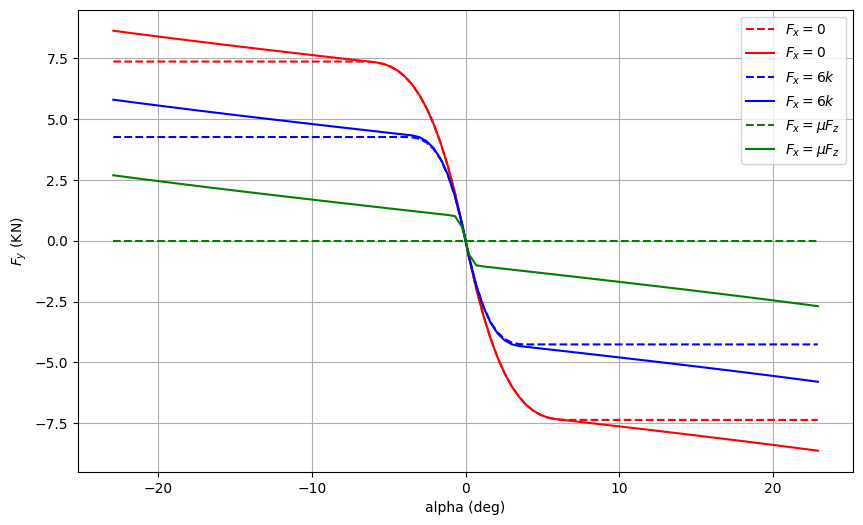

In [47]:
Fx = 0.0
alpha = np.linspace(-0.4, 0.4, 100)

plt.figure(figsize=(10, 6))

Fy = tire_model_sim(alpha, 1000 * 9.81, 0, param["C_alpha_f"], param["mu_f"])
plt.plot(np.rad2deg(alpha), Fy / 1000, "r--", label = "$F_x = 0$")

Fy = tire_model_ctrl(alpha, 1000 * 9.81, 0, param["C_alpha_f"], param["mu_f"])
plt.plot(np.rad2deg(alpha), Fy / 1000, "r-",  label = "$F_x = 0$")

Fy = tire_model_sim(alpha, 1000 * 9.81, 6000, param["C_alpha_f"], param["mu_f"])
plt.plot(np.rad2deg(alpha), Fy / 1000, "b--", label = "$F_x = 6k$")

Fy = tire_model_ctrl(alpha, 1000 * 9.81, 6000, param["C_alpha_f"], param["mu_f"])
plt.plot(np.rad2deg(alpha), Fy / 1000, "b-",  label = "$F_x = 6k$")

Fy = tire_model_sim(alpha, 1000 * 9.81, 1000 * 9.81 * param["mu_f"], param["C_alpha_f"], param["mu_f"])
plt.plot(np.rad2deg(alpha), Fy / 1000, "g--", label = "$F_x = \mu F_z$")

Fy = tire_model_ctrl(alpha, 1000 * 9.81, 1000 * 9.81 * param["mu_f"], param["C_alpha_f"], param["mu_f"])
plt.plot(np.rad2deg(alpha), Fy / 1000, "g-", label = "$F_x = \mu F_z$")

plt.ylabel("$F_y$ (KN)")
plt.xlabel("alpha (deg)")
plt.legend()
plt.grid("on")

## Nonlinear Model Predictive Control

Let the state of the car be

$$
s_k:= \left[U_{x,k}, U_{y,k}, r_k, x_k, y_k, \phi_k \right], k = 0, 1, \dots, N. 
$$

Let the control input of the car be 

$$
u_k:= \left[ F_{x, k}, \delta_{k} \right], k = 0, 1, \dots, N-1.
$$

We introduce four auxiliary variable for each step:

$$
z_k:=\left[F_{y_f, k}, F_{y_r, k}, z_{\mu_f}, z_{\mu_r}\right], k = 0, 1, \dots, N-1.
$$

The first two variables will be used to enforce the tire force constraints, which means $F_{y_f, k}$ and $F_{y_r, k}$ will be explicit variables and related to traction force $F_x$ and steering angle $\delta$ via tire model. The last two will be used to slack the friction cone constraints. 

The reason of introducing auxiliary variables is that more variabel sometimes results in less nonlinearity. 

Thus the NMPC problem will take the form:

$$
    \begin{aligned}
    J_0^{*}(s_{init}) = \min_{s_k, u_k, z_k} & \ p(s_N) + \sum_{k=0}^{N-1} q(s_k, u_k, z_k)\\ 
    \text{s.t. } 
                %  & x_{k+1} =  \ k = 0, \dots, N-1, \\
                & s_{k+1} = f(s_k, u_k, z_k), k = 0, \dots, N-1, \\
                & 0=TireModel(s_k, u_k, z_k), \\
                & FrictionCone(s_k, z_k, u_k) \le 0, \\
                & OtherConstraints(s_k, z_k, u_k) \le 0, \\
                & u_{\min} \le u_k \le u_{\max}, \\
                & x_0 = x_{init}. 
    \end{aligned}
$$

## Detail of constraints
### Friction cone constraints:

We introduce the slacked friction cone constraints:

$$ F_{y_f, k}^2 + F_{x_f, k}^2 \le (\mu_f F_{z_f, k})^2 + z_{\mu_f}^2  $$
$$ F_{y_r, k}^2 + F_{x_r, k}^2 \le (\mu_r F_{z_r, k})^2 + z_{\mu_r}^2  $$


### Obstacle avoidance:

The car should avoid colliding with the sphere obstacle:

$$ \left(\frac{x_k - 500}{10}\right)^2 + \left(\frac{y_k}{10}\right)^2 \ge 1  $$

### Input constraints:

Steering angle can not exceed the maximal value:
$$-\delta_{\max} \le \delta_k \le \delta_{\max}$$

Traction force can not exceed the engine power constraints:
$$ F_x \le \frac{P_{eng}}{U_x }$$

### Positive longitudinal speed

We do not want to drive in reverse:

$$ U_x \ge 2 $$

## Cost function design

### Stay close to the "lane":

Design a cost function to encourage the car to approach the lane: $y_k \rightarrow 0$. 

### Stabilize the yaw angle:

Design a cost function to encourage the car to maintain zero yaw angle: $\phi_k \rightarrow 0$. 

### Drive fast / far:

Design a cost function to encourage the car to drive as fast as possible, i.e. $U_x \rightarrow +\infty$ and $x \rightarrow +\infty$

### Avoid tire saturation:

Design a cost function to encourage the slip angle be smaller than the modified slip angle: 

$$
J_\alpha=W_\alpha \sum_{k=1}^N \begin{cases}\left(\left| \alpha_{k}\right|- \alpha_{k}^{\bmod }\right)^2, & \text { if }\left| \alpha_{k}\right| \geq \alpha_{k}^{\bmod } \\ 0, & \text { otherwise. }\end{cases}
$$

where $W_{\alpha}$ is a large weight. Add this cost using the **ca.if_else()** function. The $\alpha^{mod}$ is the modified slide slipping angle. 

### Penalize the slack variable of friction cone constraints:

Add a large weight to $z_{\mu_{f}}^2$ and $z_{\mu_{r}}^2$. 

## Submission

You are required to implement the controller on $5$ known test cases.

### Controller:

Please complete the function **nmpc_controller()** and submit the file. 

### Initial guess for warm-start:

Please submit the initial guess of the your NMPC solver for warm-start, i.e. the **\*.mat** files. You are supposed to compute it offline for as long as you wish untill convergence. 

We have provided examples of initial guesses for the five test cases. However, you need to compute these **\*.mat** file based on your own controller. 

### Evaluation:

We will evaluate the closed-loop trajectory based on the distance traveled in the $x$ direction and the deviation in $y$ direction. 

Larger distance in $x$ direction and less deviation from $y$ will lead to higher score. 

Collision with obstacle will result in large penalty. 

## Remark

In runtime, the NMPC is not required to converge to optimal value. We set the **ipopt.max_iter** to $100$ make sure the simulation time is reasonable. The GSI took less than $90$ secs to complete the simulation for one test cases. 

As long as the NMPC is **feasible**, suboptimal solution can still stabilize the system as long as the suboptimality is not too big. 

## Code start

### Get an NMPC controller

In [48]:
## build a controller 
prob, N_mpc, n_x, n_g, n_p, lb_var, ub_var, lb_cons, ub_cons = nmpc_controller(None)

### Compoute the solution for initial condition

You are supposed to compute the solution of your NMPC controller for each initial conditions and save it as a **case_#.mat** file. 

Only uncomment one line each time and continue. 

Once you obtained the initial guess for one cases, you can resuse it for initial guess of other cases. 

In [49]:
## random initialization
x0_nlp    = np.random.randn(n_x, 1) * 0.025 # 
lamx0_nlp = np.random.randn(n_x, 1) * 0.025 # 
lamg0_nlp = np.random.randn(n_g, 1) * 0.025 # 

## initialization using known solution
initial_guess = scipy.io.loadmat("case_1.mat") # Once you have a solution, you can use it as initial guess for other cases
x0_nlp = initial_guess["x0_nlp"]
lamx0_nlp = initial_guess["lamx0_nlp"]
lamg0_nlp = initial_guess["lamg0_nlp"]

## uncomment one line each time 
# init = np.array([50, 0.0, 0.0, 0,  0, 0]); file_name = "case_1.mat"
init = np.array([3, 0.0, 0.0, 0,  0, 0]); file_name = "case_2.mat"
# init = np.array([30, 0.0, 0., 0,  30, 0]); file_name = "case_3.mat"
# init = np.array([30, 0.0, 0.0, 0,  50, 0.3]); file_name = "case_4.mat"
# init = np.array([3, 0.0, 0.0, 0, 30, 1.57]); file_name = "case_5.mat"

## run sufficiently long time to ensure the solver converges to opitmal value
opts = {'ipopt.max_iter':3000}

solver = ca.nlpsol('solver', 'ipopt', prob , opts)
sol = solver(x0=x0_nlp, lam_x0=lamx0_nlp, lam_g0=lamg0_nlp,
                     lbx=lb_var, ubx=ub_var, lbg=lb_cons, ubg=ub_cons, p=init)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1296
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      754

Total number of variables............................:      366
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      366
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.5775309e+08 3.09e+11 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

### Compare the solutoin after warm-start

You can find the solver is fast if the initial guess is properly provided. 

Sabve the initial guess for submission and your simulations. 

In [50]:
## you will see how fast the solver is if it is initialized properly
x0_nlp    = sol["x"].full()
lamx0_nlp = sol["lam_x"].full()
lamg0_nlp = sol["lam_g"].full() # np.zeros((n_g, 1))
sol = solver(x0=x0_nlp, lam_x0=lamx0_nlp, lam_g0=lamg0_nlp,
                     lbx=lb_var, ubx=ub_var, lbg=lb_cons, ubg=ub_cons, p=init)

## save the initial guess if you are satisfied
scipy.io.savemat(file_name, {'x0_nlp': x0_nlp, "lamx0_nlp": lamx0_nlp, "lamg0_nlp": lamg0_nlp})

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1296
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      754

Total number of variables............................:      366
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      366
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.7667388e+08 3.77e+11 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [21]:
# You can plot the solution here to see if it is reasonable. 

u = sol["x"].full()[0:N_mpc * 2]
x = sol["x"].full()[N_mpc * 2:N_mpc * 2 + (N_mpc + 1) * 6]

### Retrive the initial solutions for simulation. 

If you already have the initial solutions, you can start from this block to retrive them. 

In [41]:
## test the controller with different inirial states and guesses
## uncomment one line each time and test the controller
# init = np.array([50, 0.0, 0.0, 0,  0, 0]); file_name = "case_1.mat"
# init = np.array([3, 0.0, 0.0, 0,  0, 0]); file_name = "case_2.mat"
# init = np.array([30, 0.0, 0., 0,  30, 0]); file_name = "case_3.mat"
# init = np.array([30, 0.0, 0.0, 0,  50, 0.3]); file_name = "case_4.mat"
init = np.array([3, 0.0, 0.0, 0, 30, 1.57]); file_name = "case_5.mat"

initial_guess = scipy.io.loadmat(file_name)
x0_nlp = initial_guess["x0_nlp"]
lamx0_nlp = initial_guess["lamx0_nlp"]
lamg0_nlp = initial_guess["lamg0_nlp"]

### Simulation start! 

We will simulate the vehicle for 30 secs. 

As we are using fixed-step RK simulator and limits the maximal iteration for IPOPT, the simulation time is controllable. 

In [42]:
## build a car simulator
## The car will be driving for 30 secs
## The control rate is 10 HZ.
T_sim  = 30
dt_ctrl = 0.1; rk_interval = 10
N_sim = int(np.ceil(T_sim / dt_ctrl))
integrator, car_dynamics = GetCarModel(None, ts = np.linspace(0, dt_ctrl, rk_interval), ode = "rk")
sim_time = np.linspace(0, T_sim, N_sim * (rk_interval - 1) + 1)

In [43]:
y0 = np.reshape(init, (6, 1))
x_log, u_log, tire_force_log = SimVehicle(y0, nmpc_controller, integrator, car_dynamics, N_sim, True, x0_nlp, lamx0_nlp, lamg0_nlp)

CasADi - 2023-10-19 12:58:44 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 342 (row 215, col 52).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:44 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 342 (row 215, col 52).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:44 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 342 (row 215, col 52).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:44 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:44 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:44 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
C


Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 1
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 0.007

EXIT: Invalid number in NLP function or derivative detected.

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IP

CasADi - 2023-10-19 12:58:44 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 342 (row 215, col 52).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:44 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 342 (row 215, col 52).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:44 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 390, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:44 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:44 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:44 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:44 W


Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 0.004

EXIT: Invalid number in NLP function or derivative detected.

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IP

CasADi - 2023-10-19 12:58:44 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 342 (row 215, col 52).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:44 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 342 (row 215, col 52).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:44 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 390, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:44 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:44 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:44 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:44 W


Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 0.004

EXIT: Invalid number in NLP function or derivative detected.

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IP

CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for out


Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 0.004

EXIT: Invalid number in NLP function or derivative detected.

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IP

CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for out


Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 0.005

EXIT: Invalid number in NLP function or derivative detected.

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IP

CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for out


Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 0.004

EXIT: Invalid number in NLP function or derivative detected.

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IP

CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for out


Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 0.004

EXIT: Invalid number in NLP function or derivative detected.

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IP

CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:45 WARNING("integrator:step failed: NaN detected for out


Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 0.004

EXIT: Invalid number in NLP function or derivative detected.

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IP

CasADi - 2023-10-19 12:58:46 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 342 (row 215, col 52).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:46 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 342 (row 215, col 52).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:46 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 390, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:46 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:46 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:46 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:46 W


Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 0.004

EXIT: Invalid number in NLP function or derivative detected.

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IP

CasADi - 2023-10-19 12:58:46 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:46 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:46 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:46 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:46 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:46 WARNING("integrator:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]
CasADi - 2023-10-19 12:58:46 WARNING("integrator:step failed: NaN detected for out


Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 0.005

EXIT: Invalid number in NLP function or derivative detected.

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IP

### Trajectory

You are supposed to avoid the obstacle, while trying to keep $y = 0$ and reach larger $x$. 

In [44]:
print("Distance traveled in x direction:")
print(np.max(x_log[3, :]))

print("std. dev in y direction:")
print(np.std(x_log[4, :]))

Distance traveled in x direction:
nan
std. dev in y direction:
nan


In [ ]:
# trajectory in the world frame

plt.figure(figsize=(20, 10))
plt.plot(x_log[3, 0], x_log[4, 0], "r.", markersize = 20)
plt.plot(x_log[3, :], x_log[4, :])
plt.axis("scaled")

plt.title("Trajectory")
plt.xlabel("x")
plt.ylabel("y")

theta = np.linspace(0, np.pi * 2, 100)
plt.plot(np.sin(theta) * 10 + 500, np.cos(theta) * 10)
plt.ylim([np.min(x_log[4, :]) -10, np.max(x_log[4, :]) + 10])

plt.grid()
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(sim_time, x_log[5])
plt.xlim([0, T_sim])
plt.title("Yaw Angle")
plt.xlabel("Time(s)")
plt.ylabel("rad")
plt.grid()
plt.show()

### Velocity

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(sim_time, x_log[0, :], label = "$U_x$" )
plt.xlim([0, T_sim])

plt.title("Longitudinal Velocity")
plt.xlabel("Time(s)")
plt.ylabel("m/s")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(sim_time, x_log[1, :], label = "$U_y$" )
plt.plot(sim_time, x_log[2, :], label = "$\dot{r}$" )
plt.xlim([0, T_sim])

plt.title("Lateral Velocity / Yaw rate")
plt.xlabel("Time(s)")
plt.ylabel("m/s (rad/s)")
plt.legend()
plt.grid()
plt.show()

### Control input

The traction force will decrease due to the engine power limits when the velocity is large. 

In [ ]:
rk_interval = 10
plt.figure(figsize=(20, 5))
plt.plot(sim_time[1::rk_interval-1], u_log[1, 1:])
plt.xlim([0, T_sim])
plt.title("Steering Angle")
plt.xlabel("Time(s)")
plt.ylabel("rad")
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(sim_time[1::rk_interval-1], u_log[0, 1:] / 1000)
plt.xlim([0, T_sim])
plt.title("Traction Force")
plt.xlabel("Time(s)")
plt.ylabel("kN")
plt.grid()
plt.show()

### Tire force

For successful trial, the tire force should distributed at the boundary of the friction cone for larger acceleration and braking. 

In [ ]:
rk_interval = 2
plt.figure(figsize=(20, 4))
plt.plot(sim_time[1::rk_interval-1], tire_force_log[0:3, 1:].T / 1000)
plt.title("Front Tire Forces")
plt.legend(["$F_x$", "$F_y$", "$F_z$"])
plt.ylabel("Force (kN)")
plt.xlabel("Time (s)")
plt.xlim([0, T_sim])
plt.grid()
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(sim_time[1::rk_interval-1], tire_force_log[4:7, 1:].T / 1000)
plt.title("Rear Tire Forces")
plt.legend(["$F_x$", "$F_y$", "$F_z$"])
plt.ylabel("Force (kN)")
plt.xlabel("Time (s)")
plt.xlim([0, T_sim])
plt.grid()
plt.show()

inter = 1
Fx_f = tire_force_log[0, 1::inter].T / tire_force_log[2, 1::inter].T
Fy_f = tire_force_log[1, 1::inter].T / tire_force_log[2, 1::inter].T

Fx_r = tire_force_log[4, 1::inter].T / tire_force_log[6, 1::inter].T
Fy_r = tire_force_log[5, 1::inter].T / tire_force_log[6, 1::inter].T

plt.figure(figsize=(20, 4))
plt.plot(sim_time[1::rk_interval-1], 1 - (Fx_f**2 + Fy_f**2) / param["mu_f"]**2 , label = "Front tire" )
plt.plot(sim_time[1::rk_interval-1], 1 - (Fx_r**2 + Fy_r**2) / param["mu_r"]**2 , label = "Rear tire" )
plt.title("Normalized Friction Cone")
plt.xlabel("Time (s)")
plt.xlim([0, T_sim])
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(15, 15))
plt.plot(Fx_f, Fy_f , "-o",  label = "Front tire" )
plt.plot(Fx_r, Fy_r , "-o", label = "Rear tire" )

plt.plot(Fx_f[0], Fy_f[0] , "g*")
plt.plot(Fx_r[0], Fy_r[0] , "g*")

plt.plot(np.cos(np.linspace(0, np.pi * 2, 100)) * param["mu_f"], np.sin(np.linspace(0, np.pi * 2, 100)) * param["mu_f"], "k--", label = "Front tire limits")
plt.plot(np.cos(np.linspace(0, np.pi * 2, 100)) * param["mu_r"], np.sin(np.linspace(0, np.pi * 2, 100)) * param["mu_r"], "b--", label = "Rear tire limits")

plt.title("Normalized Friction Cone")
plt.ylabel("$F_y$")
plt.xlabel("$F_x$")
plt.legend()
plt.grid()
plt.show()